In [2]:
import DriverRisk as dr
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import random
import DriverOptimization as do
import DriverDynamic as DD
import importlib

In [3]:
with open('models/xgb_amt_068.pkl', 'rb') as file:
    xgb_amt = pickle.load(file)
with open('models/xgboost_model.pkl', 'rb') as file:
    xgb_nb = pickle.load(file)

In [4]:
driver_df = pd.read_csv('data/telematics.csv')
driver_df = driver_df.drop(columns = ['Territory'])
categorical_features = ['Insured.sex','Marital','Car.use','Region']

# Create the encoder object
encoder = OneHotEncoder(drop='first', handle_unknown='ignore',sparse_output=False)

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(driver_df[categorical_features])

# Get feature names after encoding
feature_names = encoder.get_feature_names_out(categorical_features)

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=driver_df.index)

# Drop original categorical columns and concatenate encoded columns
numerical_features = [col for col in driver_df.columns if col not in categorical_features]
driver_df = pd.concat([driver_df[numerical_features], encoded_df], axis=1)

In [15]:
original_df = driver_df[0:10].copy()
premium_array = np.random.uniform(600,1200,(len(original_df),1))
#original_df['Premium'] = premium_array
sensitivity_1 = np.random.uniform(1, 2.5, len(original_df))
sensitivity_2 = np.random.uniform(0.5, 0.9, len(original_df))


In [16]:
importlib.reload(do)
total_cost = []
# build df for predicting claim probability
nb_pred_df_amount = original_df.copy().drop(columns = ['NB_Claim'])
nb_pred_df = nb_pred_df_amount.copy().drop(columns=['AMT_Claim'])
xgb_prob = xgb_nb.predict_proba(nb_pred_df)[:,1].reshape((-1, 1))
xgb_ng_pred = xgb_nb.predict(nb_pred_df)
# initialize probability history matrix
xgb_prob_matrix = xgb_prob
# build df for predicting claim amount
amount_pred_df = nb_pred_df.copy()
amount_pred_df['NB_Claim'] = xgb_ng_pred
amount_pred_df = amount_pred_df[xgb_amt.feature_names_in_]
xgb_amount = xgb_amt.predict(amount_pred_df).reshape((-1, 1))
xgb_amount = np.maximum(xgb_amount, 0)
xgb_amount_matrix = xgb_amount
total_cost.append(xgb_amount.T @ xgb_prob)
reward_matrix = np.zeros((len(nb_pred_df), 1))
reward_percentage = np.random.uniform(0, 0.2, (len(nb_pred_df), 1))
reward_matrix = np.concatenate([reward_matrix, reward_percentage], axis = 1)
T = 5
for t in range(T):
    print(f"---------Step {t}-----------------")
    nb_pred_df_amount = DD.apply_reward(nb_pred_df_amount, reward_percentage, original_df, sensitivity_1, sensitivity_2)
    nb_pred_df = nb_pred_df_amount.copy().drop(columns=['AMT_Claim'])
    xgb_prob = xgb_nb.predict_proba(nb_pred_df)[:,1].reshape((-1, 1))
    xgb_ng_pred = xgb_nb.predict(nb_pred_df)
    xgb_prob_matrix = np.concatenate([xgb_prob_matrix, xgb_prob], axis= 1)
    amount_pred_df = nb_pred_df.copy()
    amount_pred_df['NB_Claim'] = xgb_ng_pred
    amount_pred_df = amount_pred_df[xgb_amt.feature_names_in_]
    xgb_amount = xgb_amt.predict(amount_pred_df).reshape((-1, 1))
    xgb_amount = np.maximum(xgb_amount, 0)
    xgb_amount_matrix = np.concatenate([xgb_amount_matrix, xgb_amount], axis = 1)
    total_cost.append(xgb_amount.T @ xgb_prob)

    parameter_list = []
    print("----------Solving parameter fitting problem--------")
    for i in range(len(nb_pred_df)):
        # if i % 100 == 0:
        #     print(f"Driver {i}")
        print(i)
        parameter_dict = do.fit_parameters(xgb_prob_matrix[i, :], xgb_amount_matrix[i, :], reward_matrix[i, :])
        parameter_list.append(parameter_dict)
    print("-------Solving discount computing problem------")
    discount_result = do.compute_discount(parameter_list, reward_matrix, premium_array)
    
    reward_percentage = np.array(discount_result['discount']).reshape(len(nb_pred_df), 1)
    reward_matrix = np.concatenate([reward_matrix, reward_percentage], axis = 1)

    


---------Step 0-----------------
----------Solving parameter fitting problem--------
0
[0.9929133  0.91760045]
[5070.3247 5231.1196]
[0.         0.06938542]
{'x': {0: 0.0, 1: 0.01607946868956235}, 'd': {0: 0.9559981554408027, 1: 0.9559981570911956}, 'y': {0: 5070.324707030083, 1: 5231.119628905155}, 'c': 0.0, 'D': 0.9559981554408027, 'Y': 5070.324707030083, 'alpha_1': 0.0, 'alpha_2': 0.23174132358598437, 'beta_1': 1.0263979812784632e-07, 'beta_2': 0.0, 'theta_1': 10000.014613632626, 'theta_2': 0.0, 'objective_value': 0.07531286772241384}
1
[0.997682  0.9723608]
[2838.2832 3023.7673]
[0.        0.0309763]
{'x': {0: 0.0, 1: 0.01854988829550021}, 'd': {0: 0.9851027276801849, 1: 0.9851027293306062}, 'y': {0: 2838.283203121969, 1: 3023.7673339816038}, 'c': 0.0, 'D': 0.9851027276801849, 'Y': 2838.283203121969, 'alpha_1': 0.0, 'alpha_2': 0.59884126165357, 'beta_1': 8.89721169561007e-08, 'beta_2': 0.0, 'theta_1': 9999.204734005274, 'theta_2': 0.0, 'objective_value': 0.025321200470203167}
2
[0.

TypeError: 'NoneType' object is not subscriptable

In [17]:
sensitivity_2

array([0.50900659, 0.78652614, 0.73546163, 0.70706031, 0.65302107,
       0.67300821, 0.53755144, 0.80209532, 0.74200134, 0.72826214])

In [39]:
total_cost

[array([[7870.318]], dtype=float32), array([[3849.5615]], dtype=float32)]

In [40]:
reward_percentage

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [130]:
reward_percentage[1] * sensitivity_1[1]

array([0.00012167])

In [20]:
importlib.reload(do)
result_dict = do.fit_parameters([0.5,0.3], [1000,880], [0, 0.1])

results = do.compute_discount([result_dict], np.array([[0.2]]), [1000])

1000
1.0 + -1.0 <gurobi.Var *Awaiting Model Update*>
<class 'gurobipy._core.Var'>
<class 'gurobipy._core.Var'>
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[rosetta2] - Darwin 24.3.0 24D70)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 6 columns and 8 nonzeros
Model fingerprint: 0x96f9cb63
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [2e-10, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-11, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 3 rows and 4 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed



Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 387.958 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.879577335615e+02, best bound 3.879577335615e+02, gap 0.0000%


In [83]:
results

{'discount': {0: 1.0},
 'x_plus': {0: 0.0},
 'd_plus': {0: 0.5},
 'y_plus': {0: 1000.0},
 'objective_value': 500.0,
 'status': 'optimal'}

In [80]:
importlib.reload(do)
result_dict = do.fit_parameters([0.5,0.3], [1000,880], [0, 0.1])

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[rosetta2] - Darwin 24.3.0 24D70)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 19 columns and 14 nonzeros
Model fingerprint: 0x6515678b
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-01, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 4 rows and 8 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 4 rows and 12 columns
Presolve time: 0.00s
Presolved: 8 rows, 8 columns, 14 nonzeros
Presolved model has 2 bilinear constraint(s)
         in product terms.
         Presolve was not able to compute smaller bounds for these variables.
         Consider bounding these variables or reformulating the model.

Variable types: 8 continuous, 0 integer (0 binary

In [69]:
print(results)

{'discount': {0: 0.14}, 'x_plus': {0: 0.0}, 'd_plus': {0: 0.0}, 'y_plus': {0: 700.0}, 'objective_value': 860.0, 'status': 'optimal'}


In [39]:
reward_percentage = np.random.uniform(0, 1, len(driver_df))
affected_df = apply_reward(driver_df[0:100], reward_percentage[0:100], driver_df[0:100])

-2588.483547344005
-609.7123521764009
-7692.7185891341405
-465.20157563165475
-52.53013230032761
-1007.0770362252467
-5503.475525022648
-3792.4044305218886


In [56]:
for key, val in result_dict.items():
    print(key + ": " + str(type(val)))

x: <class 'dict'>
d: <class 'dict'>
y: <class 'dict'>
c: <class 'float'>
D: <class 'float'>
Y: <class 'float'>
alpha_1: <class 'float'>
alpha_2: <class 'float'>
beta_1: <class 'float'>
beta_2: <class 'float'>
theta_1: <class 'float'>
theta_2: <class 'float'>
objective_value: <class 'float'>


In [52]:
x = {t: result_dict['x'][t] for t in result_dict['x']}

In [53]:
x

{0: 0.0, 1: 1.2882427443332422e-07, 2: 7.729456465999454e-08}

In [33]:
affected_df

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,Pct.drive.tue,...,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,0.849315,8864.376247,0.148070,0.152466,...,0.000000,0.000000,1,10199.835977,1.0,0.0,1.0,0.0,0.0,1.0
1,182,44,3,575.0,12427.42,20,0.465753,8092.308208,0.147686,0.136917,...,31.303197,12.397306,1,1766.419613,0.0,0.0,1.0,0.0,0.0,1.0
2,184,48,6,847.0,12427.42,14,0.520548,3225.832512,0.153735,0.097124,...,0.000000,0.000000,0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0
3,183,71,6,842.0,6213.71,43,0.065753,253.024528,0.106702,0.056437,...,0.000000,0.000000,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
4,183,84,10,856.0,6213.71,65,0.441096,4374.379634,0.123807,0.169661,...,2.808358,1.404179,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,366,75,5,897.0,6213.71,58,0.909589,4226.510392,0.146269,0.180407,...,9.218720,1.975440,0,0.000000,1.0,1.0,0.0,0.0,1.0,1.0
96,365,56,11,895.0,12427.42,40,0.090411,1264.847007,0.135515,0.129948,...,0.000000,0.000000,0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0
97,338,32,-1,758.0,12427.42,12,0.046575,776.632477,0.158994,0.113910,...,526.143820,296.813146,0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0
98,182,72,8,896.0,6213.71,57,0.361644,2336.461823,0.101728,0.177626,...,0.000000,0.000000,0,0.000000,0.0,1.0,0.0,0.0,1.0,1.0


In [23]:
sum(affected_df[0:100]['AMT_Claim'] - driver_df['AMT_Claim'])

nan

In [22]:
driver_df[0:100]

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,Pct.drive.tue,...,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,0.849315,8864.376247,0.148070,0.152466,...,0.0,0.0,1,5100.171753,1.0,0.0,1.0,0.0,0.0,1.0
1,182,44,3,575.0,12427.42,20,0.465753,8092.308208,0.147686,0.136917,...,101.0,40.0,1,883.554840,0.0,0.0,1.0,0.0,0.0,1.0
2,184,48,6,847.0,12427.42,14,0.520548,3225.832512,0.153735,0.097124,...,0.0,0.0,0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0
3,183,71,6,842.0,6213.71,43,0.065753,253.024528,0.106702,0.056437,...,0.0,0.0,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
4,183,84,10,856.0,6213.71,65,0.441096,4374.379634,0.123807,0.169661,...,4.0,2.0,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,366,75,5,897.0,6213.71,58,0.909589,4226.510392,0.146269,0.180407,...,14.0,3.0,0,0.000000,1.0,1.0,0.0,0.0,1.0,1.0
96,365,56,11,895.0,12427.42,40,0.090411,1264.847007,0.135515,0.129948,...,0.0,0.0,0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0
97,338,32,-1,758.0,12427.42,12,0.046575,776.632477,0.158994,0.113910,...,959.0,541.0,0,0.000000,1.0,1.0,1.0,0.0,0.0,1.0
98,182,72,8,896.0,6213.71,57,0.361644,2336.461823,0.101728,0.177626,...,0.0,0.0,0,0.000000,0.0,1.0,0.0,0.0,1.0,1.0


In [47]:
affected_features = ['Accel.06miles', 'Accel.08miles', 'Accel.09miles',
       'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles',
       'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles',
       'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09',
       'Left.turn.intensity10', 'Left.turn.intensity11',
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity11', 'Right.turn.intensity12']
df_copy = driver_df.copy()
dis = [np.random.uniform(0,0.2) for i in range(len(driver_df))]
apply_reward(df_copy, dis, driver_df)

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,Pct.drive.tue,...,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,0.849315,8864.376247,0.148070,0.152466,...,0.000000,0.000000,1,10199.030196,1.0,0.0,1.0,0.0,0.0,1.0
1,182,44,3,575.0,12427.42,20,0.465753,8092.308208,0.147686,0.136917,...,100.981222,39.992563,1,1767.109494,0.0,0.0,1.0,0.0,0.0,1.0
2,184,48,6,847.0,12427.42,14,0.520548,3225.832512,0.153735,0.097124,...,0.000000,0.000000,0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0
3,183,71,6,842.0,6213.71,43,0.065753,253.024528,0.106702,0.056437,...,0.000000,0.000000,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
4,183,84,10,856.0,6213.71,65,0.441096,4374.379634,0.123807,0.169661,...,3.094881,1.547440,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,182,61,10,824.0,6213.71,42,0.161644,903.231641,0.068358,0.110253,...,0.000000,0.000000,0,0.000000,1.0,1.0,0.0,0.0,1.0,1.0
99996,192,48,3,850.0,12427.42,32,0.167123,2870.045192,0.160821,0.124073,...,-20.333305,-10.166652,0,0.000000,1.0,0.0,1.0,0.0,0.0,1.0
99997,184,50,2,650.0,6213.71,31,0.117808,935.538222,0.095132,0.076684,...,0.000000,0.000000,0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0
99998,184,76,2,811.0,6213.71,58,0.473973,4287.600459,0.106783,0.151199,...,0.000000,0.000000,0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0


In [49]:
driver_df

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,Pct.drive.tue,...,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,0.849315,8864.376247,0.148070,0.152466,...,0.0,0.0,1,5100.171753,1.0,0.0,1.0,0.0,0.0,1.0
1,182,44,3,575.0,12427.42,20,0.465753,8092.308208,0.147686,0.136917,...,101.0,40.0,1,883.554840,0.0,0.0,1.0,0.0,0.0,1.0
2,184,48,6,847.0,12427.42,14,0.520548,3225.832512,0.153735,0.097124,...,0.0,0.0,0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0
3,183,71,6,842.0,6213.71,43,0.065753,253.024528,0.106702,0.056437,...,0.0,0.0,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
4,183,84,10,856.0,6213.71,65,0.441096,4374.379634,0.123807,0.169661,...,4.0,2.0,0,0.000000,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,182,61,10,824.0,6213.71,42,0.161644,903.231641,0.068358,0.110253,...,0.0,0.0,0,0.000000,1.0,1.0,0.0,0.0,1.0,1.0
99996,192,48,3,850.0,12427.42,32,0.167123,2870.045192,0.160821,0.124073,...,22.0,11.0,0,0.000000,1.0,0.0,1.0,0.0,0.0,1.0
99997,184,50,2,650.0,6213.71,31,0.117808,935.538222,0.095132,0.076684,...,0.0,0.0,0,0.000000,1.0,1.0,1.0,0.0,0.0,0.0
99998,184,76,2,811.0,6213.71,58,0.473973,4287.600459,0.106783,0.151199,...,0.0,0.0,0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0


In [36]:
a = np.array(driver_df.iloc[1][['Accel.06miles', 'Accel.08miles', 'Accel.09miles',
       'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles',
       'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles',
       'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09',
       'Left.turn.intensity10', 'Left.turn.intensity11',
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity11', 'Right.turn.intensity12']] - driver_df.iloc[1][['Accel.06miles', 'Accel.08miles', 'Accel.09miles',
       'Accel.11miles', 'Accel.12miles', 'Accel.14miles', 'Brake.06miles',
       'Brake.08miles', 'Brake.09miles', 'Brake.11miles', 'Brake.12miles',
       'Brake.14miles', 'Left.turn.intensity08', 'Left.turn.intensity09',
       'Left.turn.intensity10', 'Left.turn.intensity11',
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity11', 'Right.turn.intensity12']])


SyntaxError: unmatched ']' (2373665909.py, line 8)

In [42]:
0.5 * driver_df.loc[1,"AMT_Claim"]

441.77742

In [59]:
driver_df_1 = driver_df.copy()

# Method 2: Using map with lambda
driver_df_1['NB_Claim'] = driver_df_1['NB_Claim'].map(lambda x: 1 if x > 0 else 0)

driver_df_1_train = driver_df_1
driver_df_amt = driver_df_1_train.copy()
X_nb = driver_df_1_train.drop(["NB_Claim", "AMT_Claim"], axis=1)
X_amt = driver_df_amt.drop('AMT_Claim', axis=1)
#X = driver_df_1_train
y_amt = driver_df_amt['AMT_Claim']

In [52]:
amt_predict = xgb_amt.predict(X_amt)

In [63]:
sum(amt_predict * y_pred_proba)

12366921.47039229

In [60]:
y_pred_proba = xgb_nb.predict_proba(X_nb)[:, 1]

In [65]:
(1376 - 1237)/1376

0.10101744186046512

In [74]:
driver_df["NB_Claim"] >= 1

0         True
1         True
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: NB_Claim, Length: 100000, dtype: bool

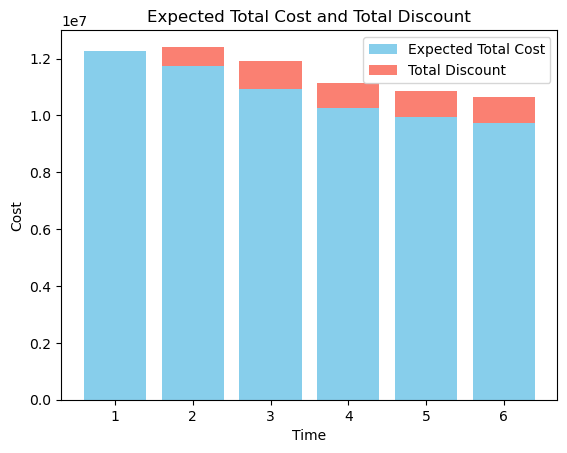

In [169]:
plt.bar(range(1, 7), Expected_total_cost, color='skyblue', label='Expected Total Cost')

# Plot the second set of bars on top, using the first set as the bottom
plt.bar(range(1, 7), discount_cost, bottom=Expected_total_cost, color='salmon', label='Total Discount')
plt.title("Total Epected Cost and Total Discount")
plt.xlabel('Time')
plt.ylabel('Cost')
plt.ylim(0, 13000000)
plt.title('Expected Total Cost and Total Discount')
plt.legend()
plt.show()

In [95]:
sum(y_pred_proba > 0.95)

3446

(array([9.5413e+04, 4.6500e+02, 1.3300e+02, 1.0000e+02, 6.3000e+01,
        5.7000e+01, 7.0000e+01, 7.2000e+01, 9.6000e+01, 3.5310e+03]),
 array([8.81504457e-06, 9.99963731e-02, 1.99983925e-01, 2.99971491e-01,
        3.99959028e-01, 4.99946594e-01, 5.99934161e-01, 6.99921727e-01,
        7.99909234e-01, 8.99896801e-01, 9.99884367e-01]),
 <BarContainer object of 10 artists>)

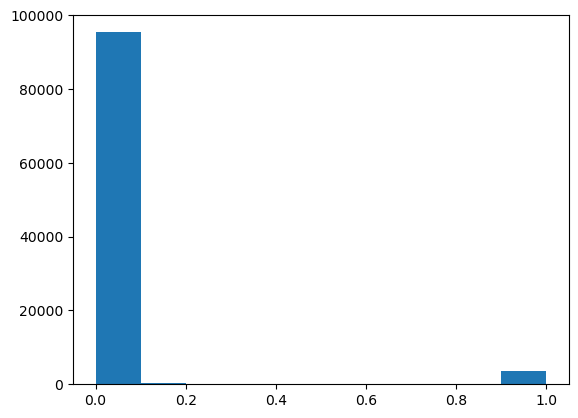

In [112]:
plt.hist(y_pred_proba)

In [118]:
from scipy.stats import norm
c_list = []
for i in range(len(y_pred_proba)):
    if y_pred_proba[i] < 0.5:
        c = np.random.uniform(0, 0.1)
        c_list.append(c)
    else:
        c = np.random.uniform(0.35,0.5)
        c_list.append(c)
        

In [119]:
c_list

[0.4477965099329607,
 0.438549172266589,
 0.05669519542728505,
 0.08124964506533447,
 0.0884020503596095,
 0.052187636993753006,
 0.0720698823021904,
 0.0192097548006283,
 0.06895085534292122,
 0.00644782870840881,
 0.006975204725188255,
 0.007087590375424835,
 0.039841173595329474,
 0.0991120067079406,
 0.4955982798072791,
 0.009371483098735789,
 0.020322285953688027,
 0.03612061558797317,
 0.04012964120554727,
 0.0644191231962825,
 0.038208550166595634,
 0.07678842254151118,
 0.08102398148524764,
 0.07706073673301429,
 0.034179296755032396,
 0.0666884897308338,
 0.0030189653624822736,
 0.4964621039431164,
 0.061720498523072015,
 0.014159036030302231,
 0.0027378616485062347,
 0.06181021346937959,
 0.05636582885949102,
 0.09418426514719037,
 0.014223239880194416,
 0.05676383799432754,
 0.08785440057813242,
 0.06807640564298671,
 0.03429253917132431,
 0.04652433130984569,
 0.054225514329415574,
 0.06285676895561697,
 0.4474341560943385,
 0.392142169160216,
 0.06832001957341868,
 0.07365

In [124]:
alpha = np.random.uniform(1,2.5, size=100000)
new_sequence = np.random.randn(len(alpha))

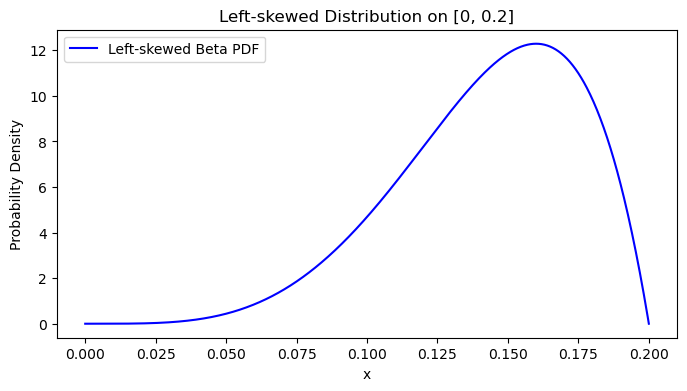

In [128]:
from scipy.stats import beta
alpha, beta_param = 5, 2

# Create an array of values on [0, 1]
x = np.linspace(0, 1, 1000)

# Compute the Beta PDF on [0,1]
pdf = beta.pdf(x, alpha, beta_param)

# Scale x to the interval [0, 0.2]
x_scaled = x * 0.2

# Adjust the PDF for the new scale (divide by 0.2)
pdf_scaled = pdf / 0.2

# Plot the scaled PDF
plt.figure(figsize=(8, 4))
plt.plot(x_scaled, pdf_scaled, label='Left-skewed Beta PDF', color='blue')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Left-skewed Distribution on [0, 0.2]')
plt.legend()
plt.show()

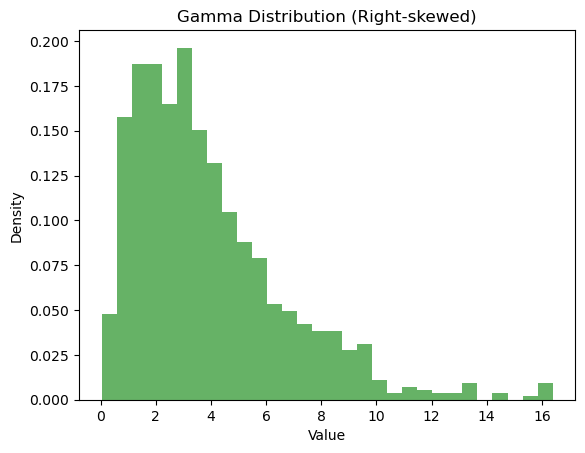

In [129]:

# Generate 1000 samples from a Gamma distribution with shape=2.0, scale=2.0
samples_gamma = np.random.gamma(shape=2.0, scale=2.0, size=1000)
plt.hist(samples_gamma, bins=30, density=True, alpha=0.6, color='g')
plt.title('Gamma Distribution (Right-skewed)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

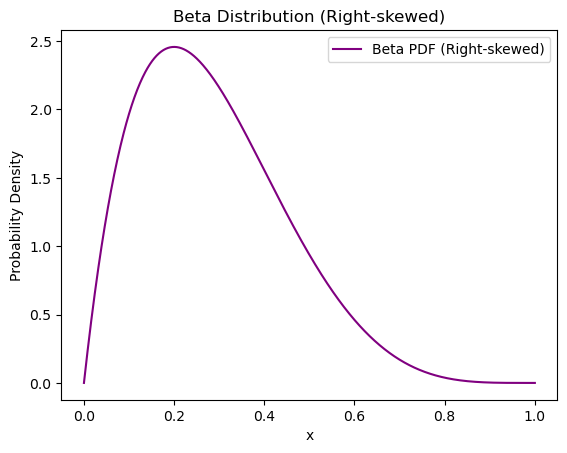

In [130]:
alpha, beta_param = 2, 5
x = np.linspace(0, 1, 1000)
pdf = beta.pdf(x, alpha, beta_param)

plt.plot(x, pdf, label="Beta PDF (Right-skewed)", color='purple')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Beta Distribution (Right-skewed)')
plt.legend()
plt.show()